# Справочная информация:
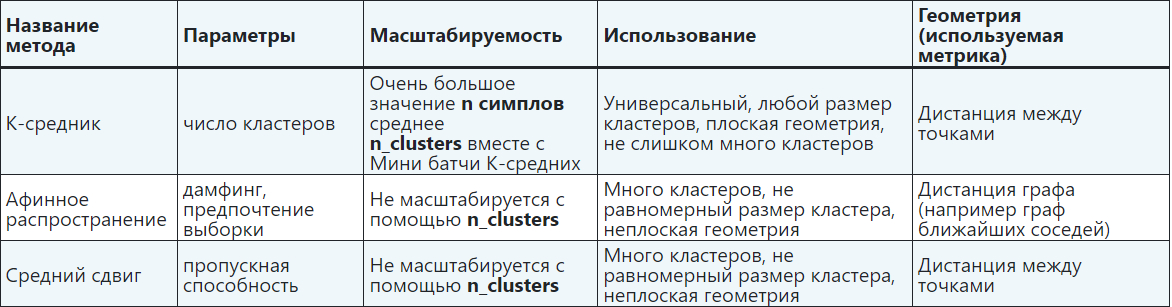
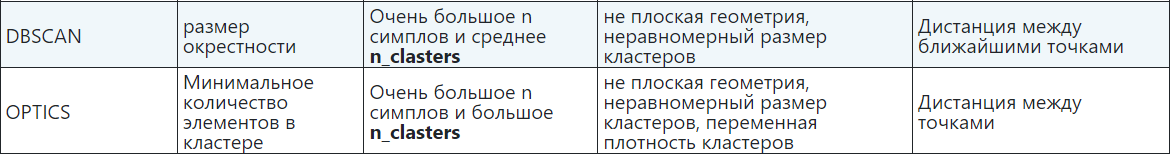

**Метрики для оценки точности кластеризации:**

*Евклидово расстояние (Euclidean Distance)*

Определение: Евклидово расстояние между двумя точками в n-мерном пространстве - это длина отрезка, соединяющего эти точки. Оно вычисляется как квадратный корень из суммы квадратов разностей соответствующих координат.


---


*Манхэттенское расстояние (Manhattan Distance)*

Определение: Манхэттенское расстояние между двумя точками в n-мерном пространстве - это сумма абсолютных разностей их координат. Его также называют "городским" расстоянием, так как оно измеряет расстояние по прямым углам, как в городских кварталах.


---


*Косинусное расстояние (Cosine Distance)*

Определение: Косинусное расстояние между двумя векторами измеряет угол между ними, а не их евклидову или манхэттенскую дистанцию. Косинусное расстояние используется в задачах, где важно направление векторов, а не их длина, например, в текстовом анализе.

In [ ]:
import numpy as np
import pandas as pd
import warnings
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift, AffinityPropagation, DBSCAN, OPTICS
from sklearn.metrics import adjusted_rand_score, pairwise_distances, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning

In [ ]:
# Подавление всех FutureWarning и ConvergenceWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [ ]:
# Загрузка датасетов
datasets_list = [
    datasets.load_iris(),
    datasets.load_breast_cancer(),
    datasets.load_digits(),
    datasets.load_wine()
]

# Имена метрик
metrics = ['euclidean', 'manhattan', 'cosine']

In [ ]:
# Настройки кластеризации
cluster_settings = {
    'iris': [2, 3, 4],  # реальное количество кластеров для Ирисов - 3 (±1)
    'breast_cancer': [1, 2, 3],  # реальное количество кластеров для Рака - 2 (±1)
    'digits': [9, 10, 11],  # реальное количество кластеров для Цифр - 10 (±1)
    'wine': [2, 3, 4]  # реальное количество кластеров для Вина - 3 (±1)
}

In [ ]:
# Преобразование названий датасетов для использования в ключах словаря
dataset_names = ['iris', 'breast_cancer', 'digits', 'wine']

# Создание функции для оценки качества кластеризации
def evaluate_clustering(labels_true, labels_pred):
  #путем сравнения двух наборов меток кластеров: истинных меток (labels_true) и предсказанных меток (labels_pred)
    return adjusted_rand_score(labels_true, labels_pred)

# Стандартизация данных и применение кластеризации
results = {}          # Словарь для хранения результатов кластеризации
cluster_labels = {}   # Словарь для хранения результатов кластеризации

In [ ]:
for dataset, name in zip(datasets_list, dataset_names):
    data = dataset.data       # Данные из набора данных
    target = dataset.target   # Истинные метки кластеров из набора данных
    results[name] = {}        # Словарь для хранения результатов кластеризации для данного набора данных
    cluster_labels[name] = {} # Словарь для хранения меток кластеров

    # Стандартизация данных
    scaler = StandardScaler()
    # выполняет масштабирование данных с использованием выбранного скалера
    data_scaled = scaler.fit_transform(data)

    for metric in metrics:
        results[name][metric] = {}           # Словарь для хранения результатов кластеризации
        cluster_labels[name][metric] = {}    # Словарь для хранения меток кластеров

        # Применение алгоритма KMeans с использованием евклидовой метрики

        for n_clusters in cluster_settings[name]:
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)               # Создание объекта KMeans/ n_cluster определяет кол-во класетров,
                                                                                  # random_state=42 определяет генерацию случайных чисел для инициализации центроида
            kmeans.fit(data_scaled)                                               # Применение алгоритма к данным
            labels_kmeans = kmeans.labels_                                        # Получение меток кластеров
            score_kmeans = evaluate_clustering(target, labels_kmeans)             # Оценка качества кластеризации
            results[name][metric][f'KMeans_{n_clusters}'] = score_kmeans          # Сохранение результатов
            cluster_labels[name][metric][f'KMeans_{n_clusters}'] = labels_kmeans  # Сохранение меток кластеров

        # Применение MeanShift
        try:
            mean_shift = MeanShift()
            mean_shift.fit(data_scaled)
            labels_mean_shift = mean_shift.labels_
            score_mean_shift = evaluate_clustering(target, labels_mean_shift)
            results[name][metric]['MeanShift'] = score_mean_shift
            cluster_labels[name][metric]['MeanShift'] = labels_mean_shift
        except Exception as e:
            results[name][metric]['MeanShift'] = f"Error: {e}"      # Обработка возможной ошибки

        # Применение AffinityPropagation
        try:
            affinity_propagation = AffinityPropagation(max_iter=1000)
            affinity_propagation.fit(data_scaled)
            labels_affinity_propagation = affinity_propagation.labels_
            score_affinity_propagation = evaluate_clustering(target, labels_affinity_propagation)
            results[name][metric]['AffinityPropagation'] = score_affinity_propagation
            cluster_labels[name][metric]['AffinityPropagation'] = labels_affinity_propagation
        except Exception as e:
            results[name][metric]['AffinityPropagation'] = f"Error: {e}"

        # Применение DBSCAN
        try:
            dbscan = DBSCAN(metric=metric, eps=0.5) #metric Метрика, используемая при вычислении расстояния между экземплярами в массиве объектов
                                                    #eps=0.5 Максимальное расстояние между двумя выборками,
                                                    #при котором одна выборка считается расположенной по соседству с другой.
            dbscan.fit(data_scaled)
            labels_dbscan = dbscan.labels_
            score_dbscan = evaluate_clustering(target, labels_dbscan)
            results[name][metric]['DBSCAN'] = score_dbscan
            cluster_labels[name][metric]['DBSCAN'] = labels_dbscan
        except Exception as e:
            results[name][metric]['DBSCAN'] = f"Error: {e}"

        # Применение OPTICS
        try:
            optics = OPTICS(metric=metric)
            optics.fit(data_scaled)
            labels_optics = optics.labels_
            score_optics = evaluate_clustering(target, labels_optics)
            results[name][metric]['OPTICS'] = score_optics
            cluster_labels[name][metric]['OPTICS'] = labels_optics
        except Exception as e:
            results[name][metric]['OPTICS'] = f"Error: {e}"

In [ ]:
# Функция для вывода результатов "Оценка качества кластеризации" и визуализации для конкретного датасета
def print_results(dataset_name):
    if dataset_name in results:                           # Проверка наличия результатов для данного набора данных
        print(f"Dataset: {dataset_name}")
        metrics_dict = results[dataset_name]              # Получение результатов для данного набора данных
        for metric, methods_dict in metrics_dict.items(): # Перебор результатов для каждой метрики
            print(f"  Metric: {metric}")
            for method, score in methods_dict.items():     # Перебор результатов для каждого метода
                print(f"    {method}: {score}")




Dataset: iris
  Metric: euclidean
    KMeans_2: 0.5681159420289855
    KMeans_3: 0.6201351808870379
    KMeans_4: 0.4728177114181946
    MeanShift: 0.5681159420289855
    AffinityPropagation: 0.3702605927346578
    DBSCAN: 0.4420986685885924
    OPTICS: 0.05141642728695205
  Metric: manhattan
    KMeans_2: 0.5681159420289855
    KMeans_3: 0.6201351808870379
    KMeans_4: 0.4728177114181946
    MeanShift: 0.5681159420289855
    AffinityPropagation: 0.3702605927346578
    DBSCAN: 0.12294874418572385
    OPTICS: 0.09022913899287525
  Metric: cosine
    KMeans_2: 0.5681159420289855
    KMeans_3: 0.6201351808870379
    KMeans_4: 0.4728177114181946
    MeanShift: 0.5681159420289855
    AffinityPropagation: 0.3702605927346578
    DBSCAN: 0.0
    OPTICS: 0.07976150846168628


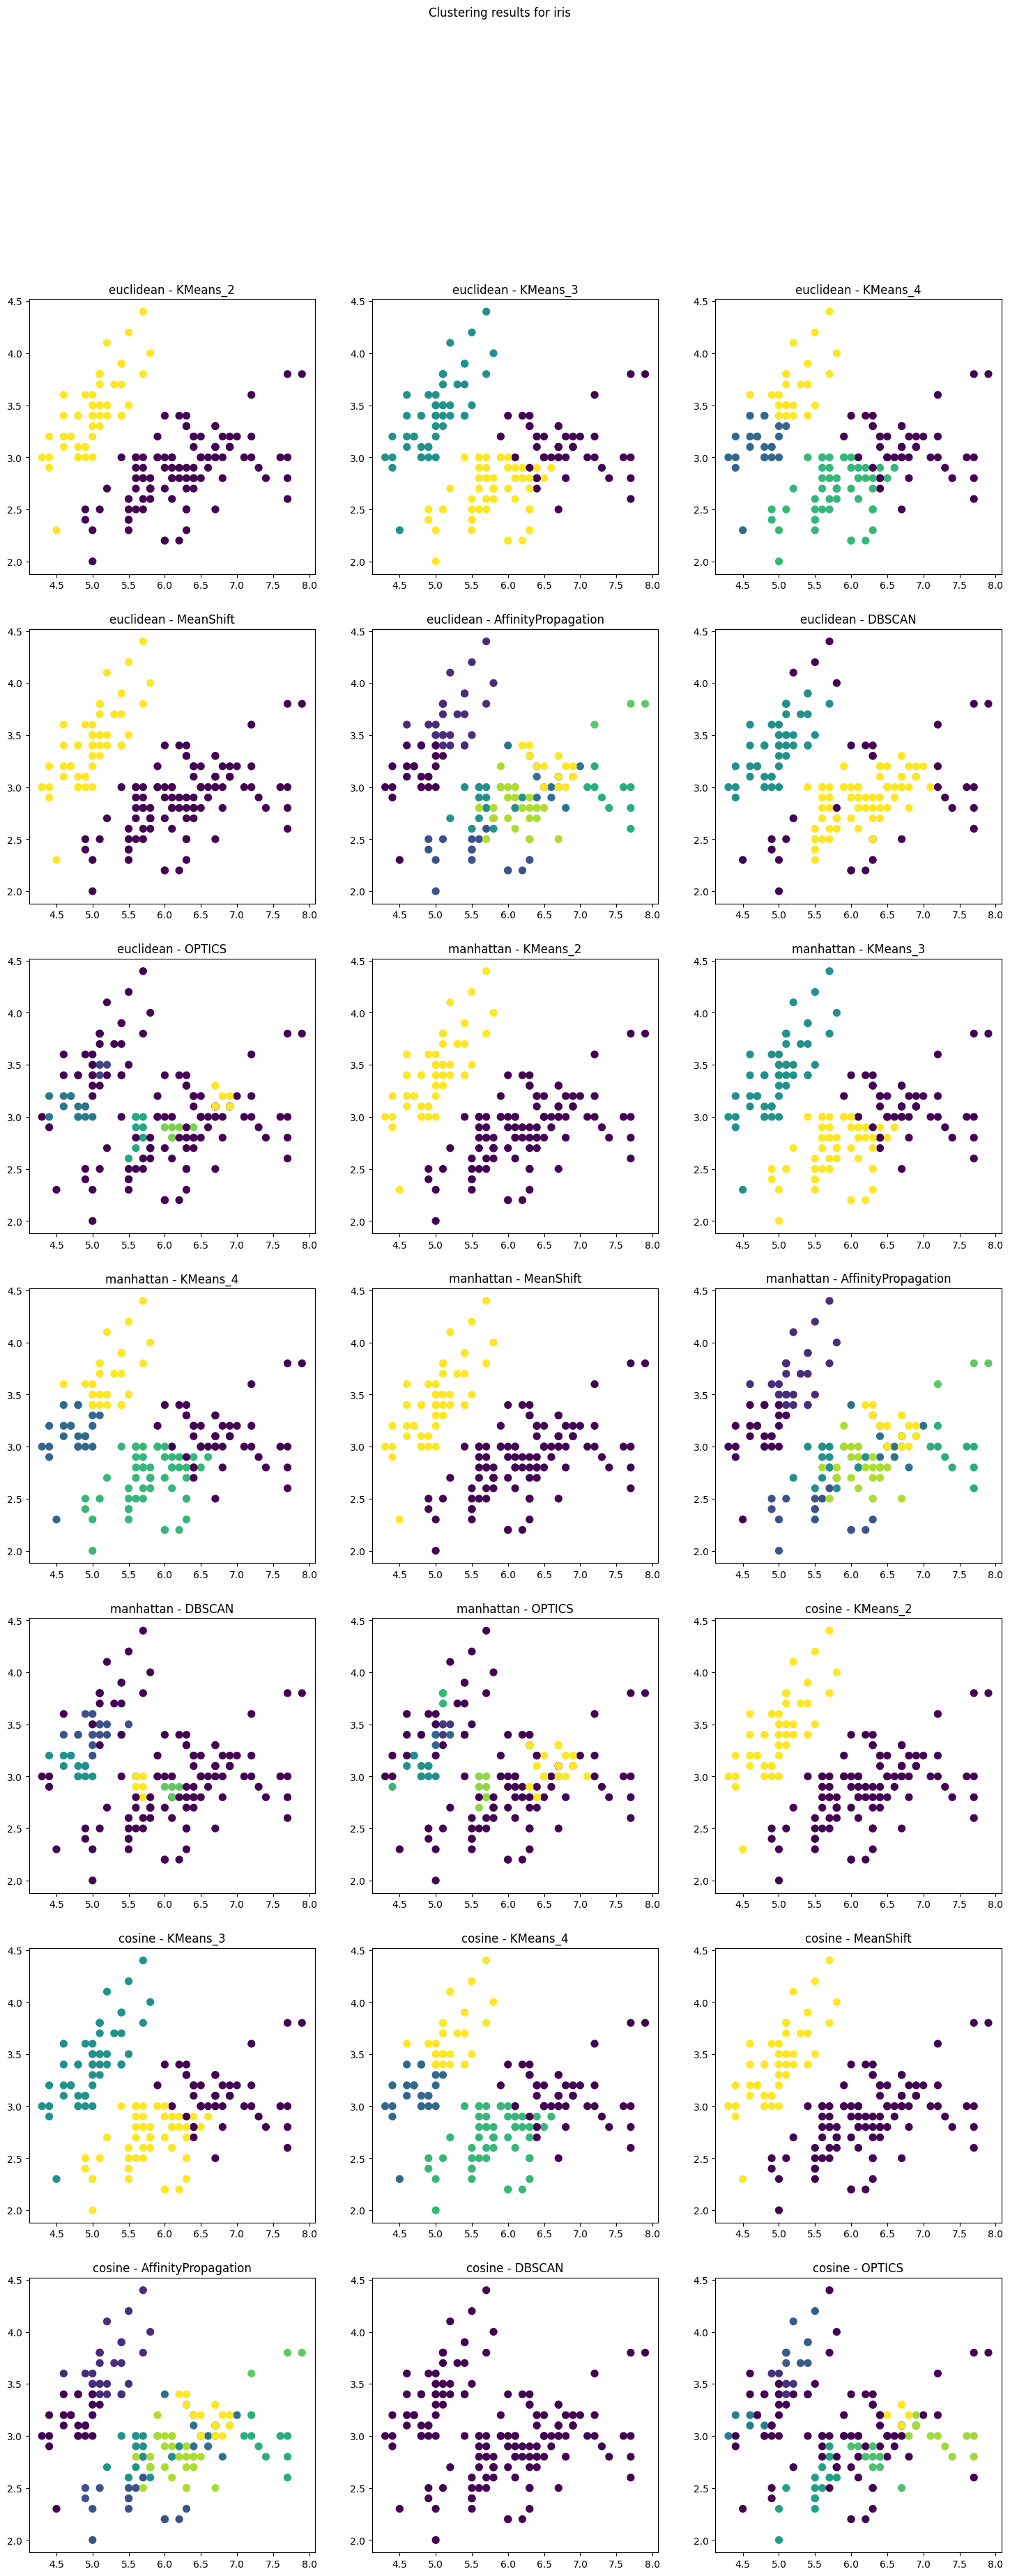

In [ ]:
# Пример вызова функции для вывода результатов для одного датасета
print_results('iris')

Dataset: breast_cancer
  Metric: euclidean
    KMeans_1: 0.0
    KMeans_2: 0.6707206476880808
    KMeans_3: 0.510670959369618
    MeanShift: 0.12788720011061896
    AffinityPropagation: 0.04855359904817497
    DBSCAN: 0.0
    OPTICS: 0.02766435305873905
  Metric: manhattan
    KMeans_1: 0.0
    KMeans_2: 0.6707206476880808
    KMeans_3: 0.510670959369618
    MeanShift: 0.12788720011061896
    AffinityPropagation: 0.04855359904817497
    DBSCAN: 0.0
    OPTICS: 0.03777741047032805
  Metric: cosine
    KMeans_1: 0.0
    KMeans_2: 0.6707206476880808
    KMeans_3: 0.510670959369618
    MeanShift: 0.12788720011061896
    AffinityPropagation: 0.04855359904817497
    DBSCAN: 0.0
    OPTICS: -0.010821969338918838


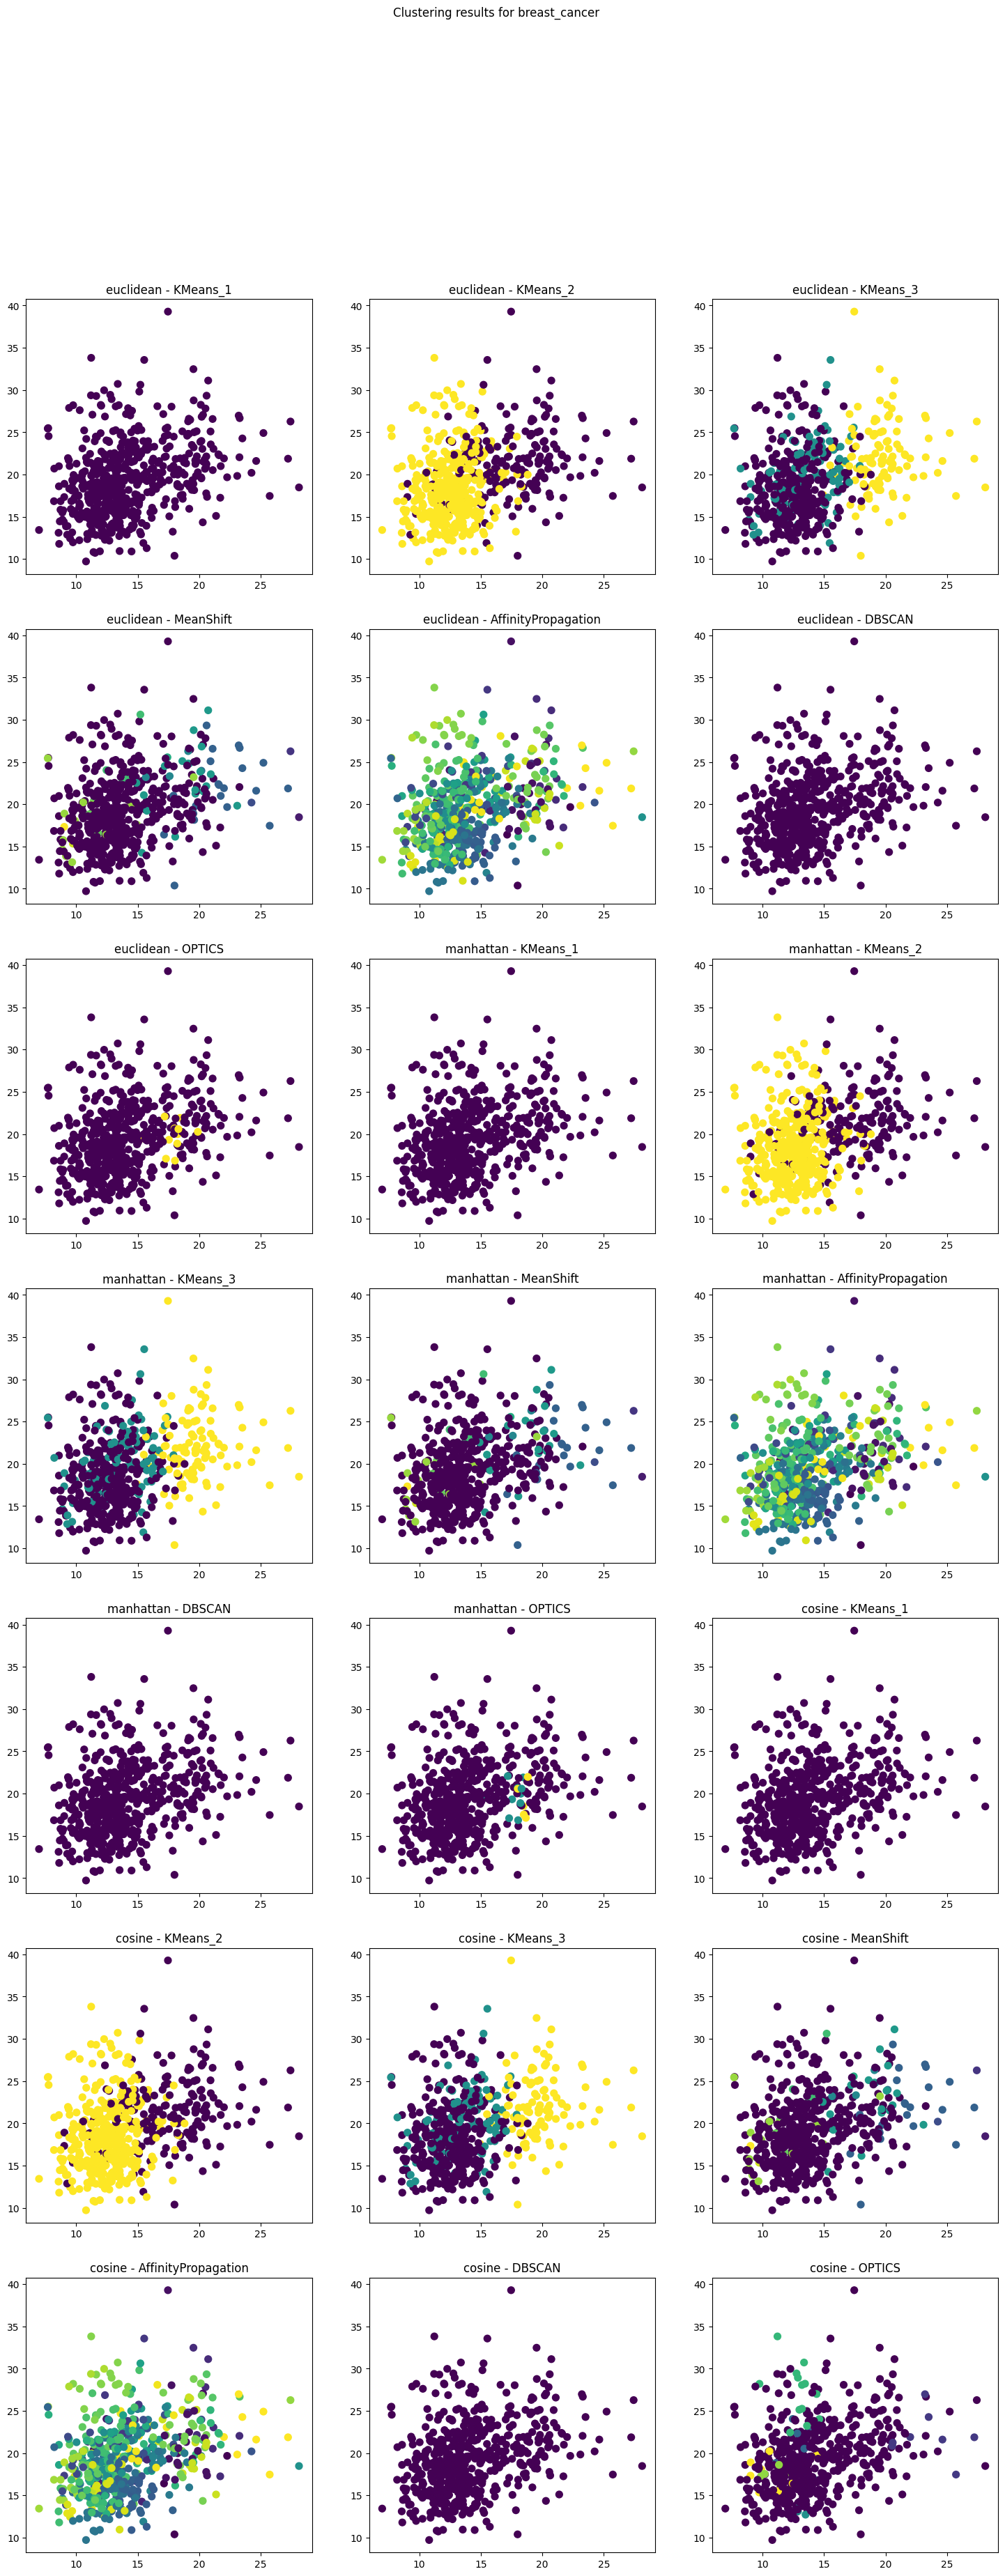

In [ ]:
print_results('breast_cancer')

Dataset: digits
  Metric: euclidean
    KMeans_9: 0.4023824005292775
    KMeans_10: 0.4654932987132127
    KMeans_11: 0.5347858556378161
    MeanShift: 8.37350466209837e-05
    AffinityPropagation: 0.1543890171236833
    DBSCAN: 0.0
    OPTICS: 0.00362992381144297
  Metric: manhattan
    KMeans_9: 0.4023824005292775
    KMeans_10: 0.4654932987132127
    KMeans_11: 0.5347858556378161
    MeanShift: 8.37350466209837e-05
    AffinityPropagation: 0.1543890171236833
    DBSCAN: 0.0
    OPTICS: 0.00232713972223083
  Metric: cosine
    KMeans_9: 0.4023824005292775
    KMeans_10: 0.4654932987132127
    KMeans_11: 0.5347858556378161
    MeanShift: 8.37350466209837e-05
    AffinityPropagation: 0.1543890171236833
    DBSCAN: 2.2315991395101293e-06
    OPTICS: 0.004742840884901005


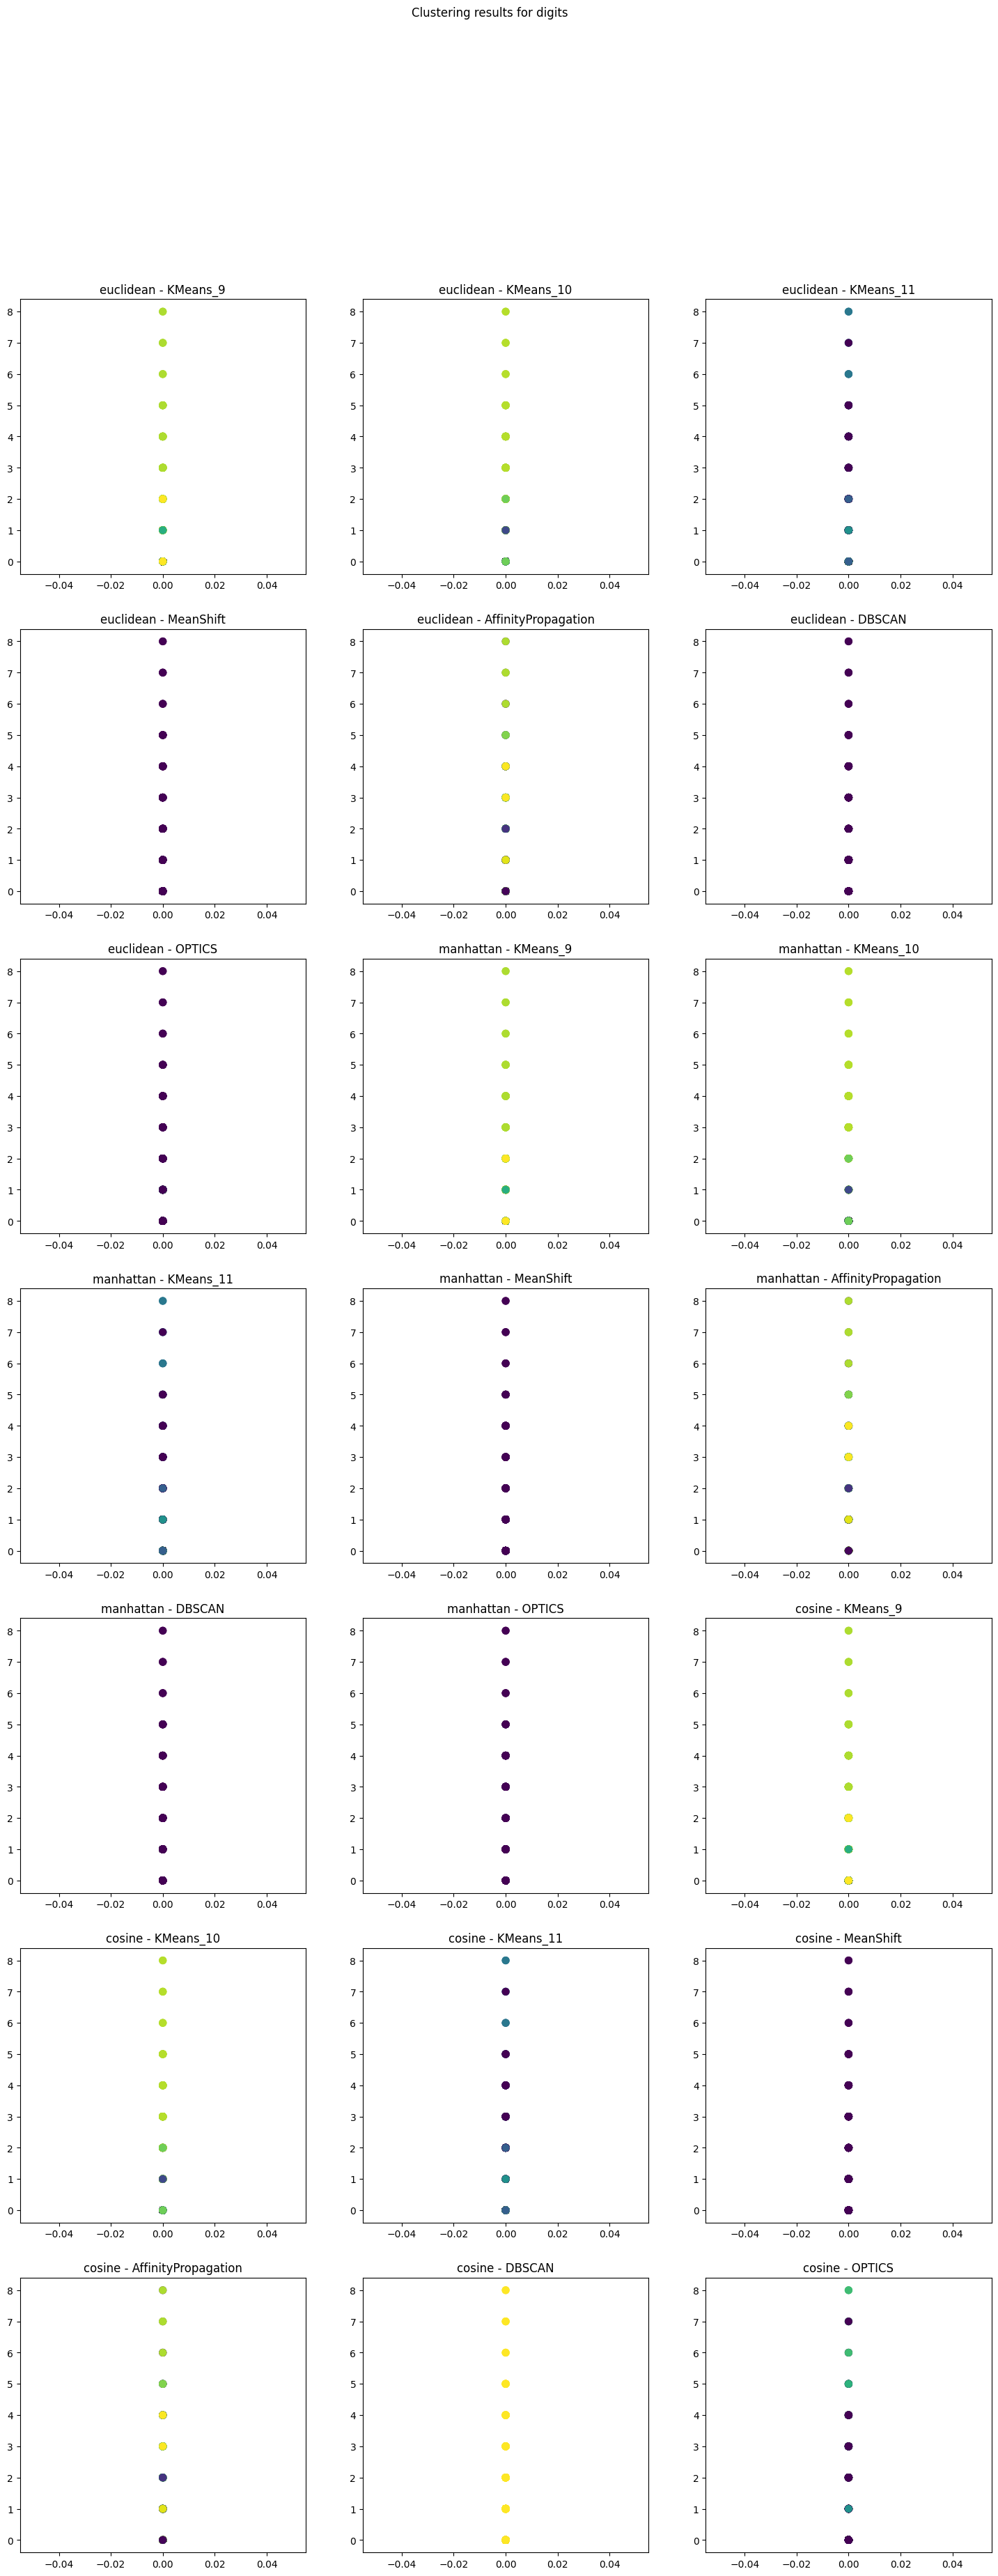

In [ ]:
print_results('digits')

Dataset: wine
  Metric: euclidean
    KMeans_2: 0.38872424979619347
    KMeans_3: 0.8974949815093207
    KMeans_4: 0.7491735027058888
    MeanShift: -0.0064242403723043275
    AffinityPropagation: 0.2728590642231466
    DBSCAN: 0.0
    OPTICS: 0.03581729799518326
  Metric: manhattan
    KMeans_2: 0.38872424979619347
    KMeans_3: 0.8974949815093207
    KMeans_4: 0.7491735027058888
    MeanShift: -0.0064242403723043275
    AffinityPropagation: 0.2728590642231466
    DBSCAN: 0.0
    OPTICS: 0.03740656802338495
  Metric: cosine
    KMeans_2: 0.38872424979619347
    KMeans_3: 0.8974949815093207
    KMeans_4: 0.7491735027058888
    MeanShift: -0.0064242403723043275
    AffinityPropagation: 0.2728590642231466
    DBSCAN: 0.0
    OPTICS: 0.016119662732131997


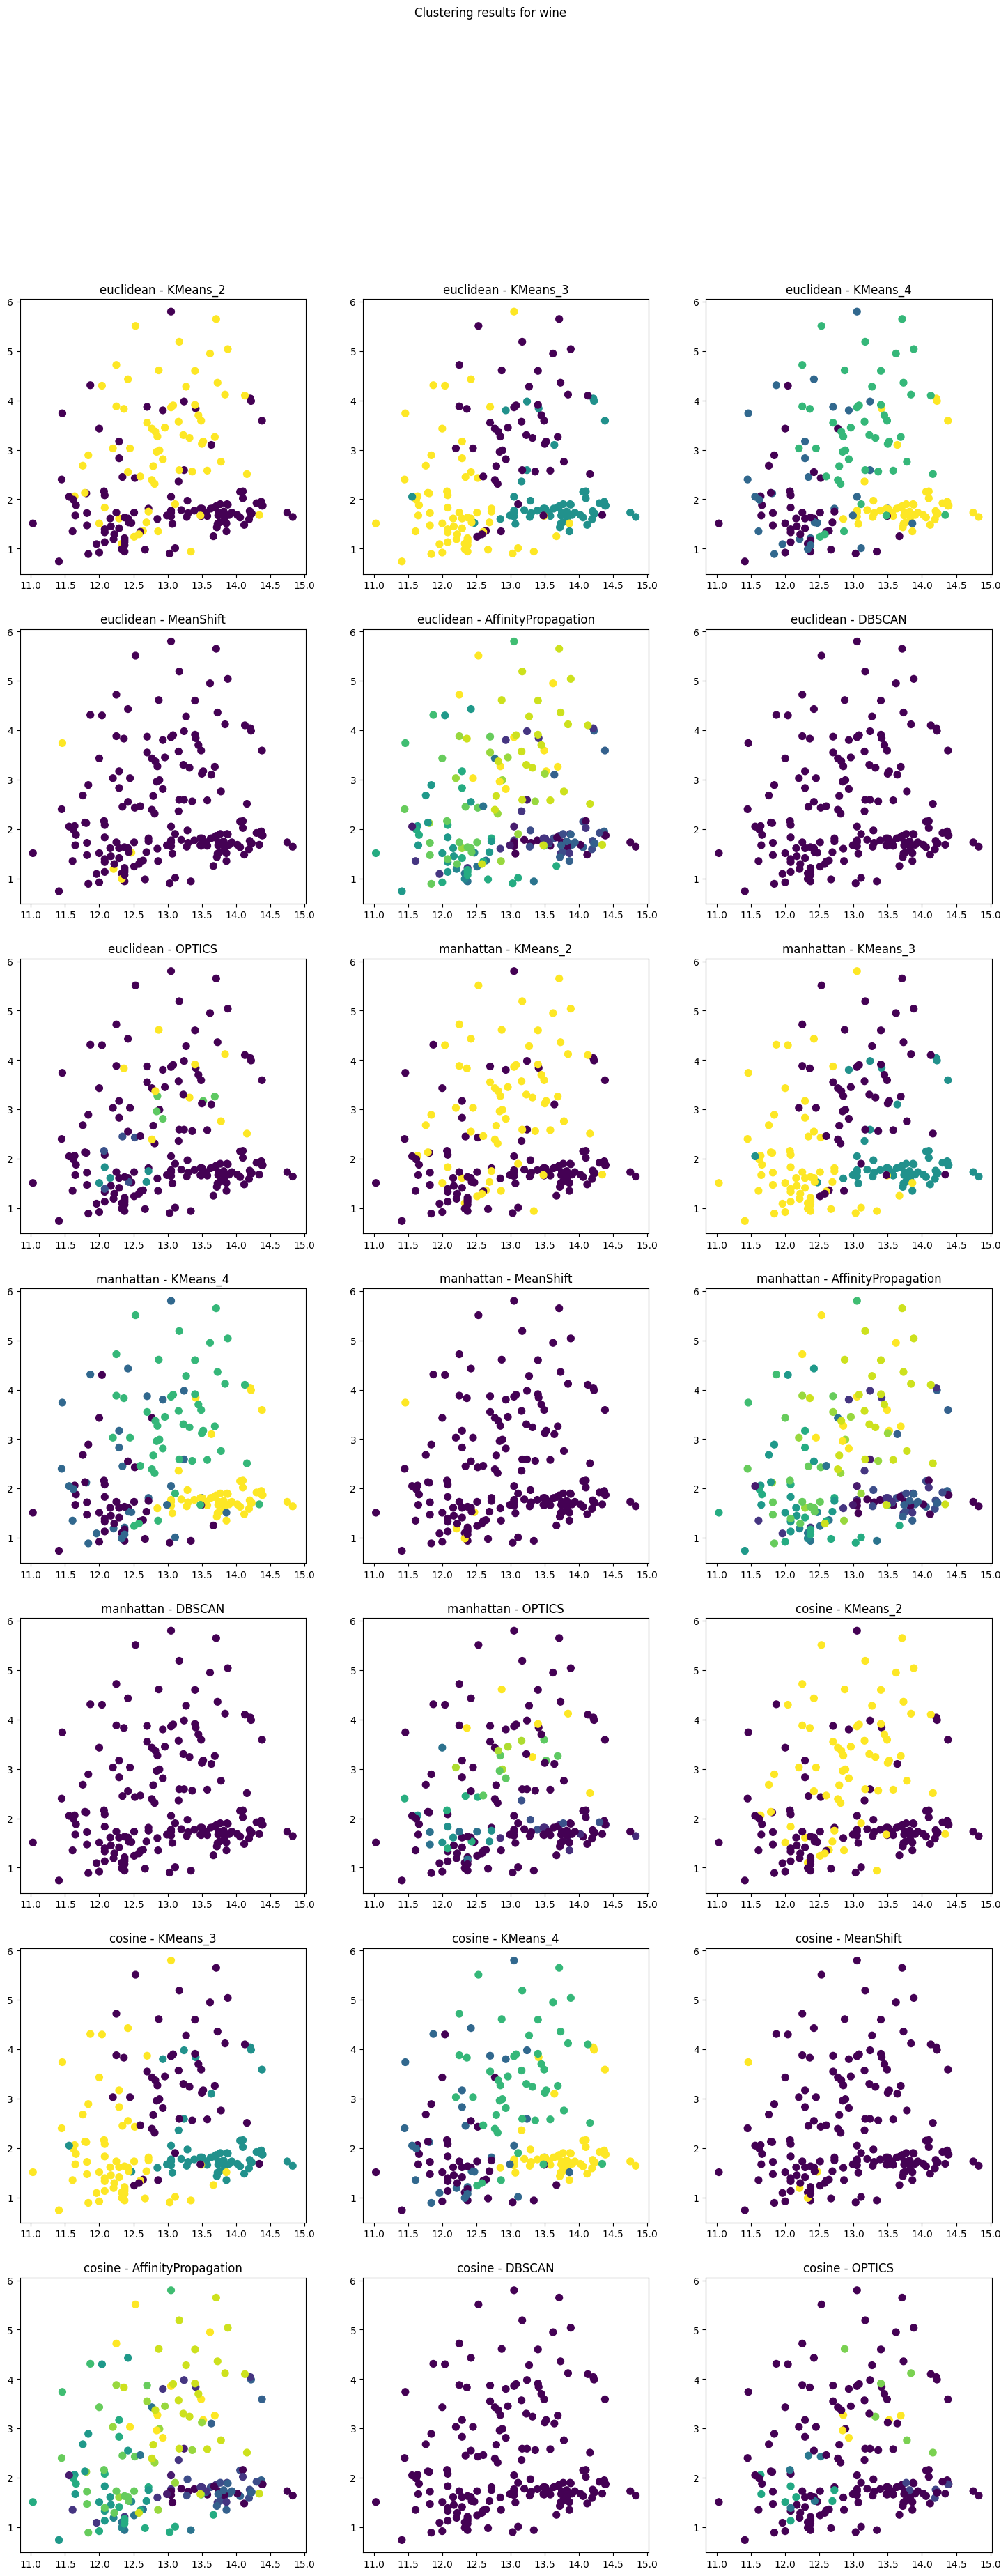

In [ ]:
print_results('wine')

In [ ]:
# Выбор наилучшего метода кластеризации
def choose_best_clustering_method(datasets_list, cluster_labels, results):
    best_methods = {}

    for dataset_name, methods_dict in cluster_labels.items():     # Перебор наборов данных и их методов кластеризации
        best_metric = None
        best_method = None
        best_score = float('-inf')  # Начальное значение для сравнения результатов

        for metric, methods in methods_dict.items():                          # Перебор метрик и их методов кластеризации
            for method, labels in methods.items():                            # Перебор методов и соответствующих меток кластеров
                if isinstance(results[dataset_name][metric][method], float):  # Игнорируем ошибки/# Проверка наличия валидной оценки качества кластеризации
                    score = results[dataset_name][metric][method]              # Получение оценки качества кластеризации
                    if score > best_score:
                        best_score = score
                        best_metric = metric
                        best_method = method

        best_methods[dataset_name] = {'metric': best_metric, 'method': best_method, 'score': best_score}  # Сохранение лучших результатов для данного набора данных

    return best_methods

best_methods = choose_best_clustering_method(datasets_list, cluster_labels, results)  # Выбор лучших методов кластеризации для всех наборов данных

In [ ]:
for dataset_name, info in best_methods.items():
    print(f"Dataset: {dataset_name}")
    print(f"  Best Metric: {info['metric']}")
    print(f"  Best Method: {info['method']}")
    print(f"  Best Score: {info['score']}\n")

Dataset: iris
  Best Metric: euclidean
  Best Method: KMeans_3
  Best Score: 0.6201351808870379

Dataset: breast_cancer
  Best Metric: euclidean
  Best Method: KMeans_2
  Best Score: 0.6707206476880808

Dataset: digits
  Best Metric: euclidean
  Best Method: KMeans_11
  Best Score: 0.5347858556378161

Dataset: wine
  Best Metric: euclidean
  Best Method: KMeans_3
  Best Score: 0.8974949815093207

